In [9]:

# Experiment setup:
# First, train a model on the original training data
# Second, train a model with noise on the 0-250ms region
# Third, train a model with noise on the 250-500ms regions
# Lastly, take 5-10 SHAP approximation per model (depends on the computing time)
# And make sure the SHAP per participant uses the same fixed sets for the approximation

In [2]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
from src.model.variance_wrapper import EEGVarianceWrapper
import copy
import random
import pickle
import torch
import shap
from src.plotting import plot_shap_heatmap

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-ji

In [2]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [10]:
def add_guassian_noise_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        channels_to_corrupt = int(64 / 10 * severity_index)
        dataset[0][episode] = add_gaussian_noise(dataset[0][episode], 2 * severity_index, channels_to_corrupt, low, high)

    return dataset

In [11]:
def add_zero_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset
    
    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
            # Can range from 5-50%
        channels_to_corrupt = int(64 / 20 * severity_index)
            # Zeroes the entire signal
        dataset[0][episode] = zero_signal(dataset[0][episode], channels_to_corrupt, low, high, 100)

    return dataset

In [ ]:
shap_values = [[] for _ in range(3)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', 1)

    for i in range(3):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        if i != 0:
            train_copy = add_guassian_noise_to_dataset(train_copy, 10, low = (i - 1) * 128, high = i * 128 - 1)
            val_copy = add_guassian_noise_to_dataset(val_copy, 10, low = (i - 1) * 128, high = i * 128 - 1)
            test_copy = add_guassian_noise_to_dataset(test_copy, 10, low = (i - 1) * 128, high = i * 128 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)

        test_shap = list()

        shap_test_tensor = torch.empty((0, 1, 64, 308), dtype=torch.float32)

        for (data, _) in dm.test_dataloader():
            shap_test_tensor = torch.cat((shap_test_tensor, data), 0)

        background = shap_test_tensor[:-10]
        test_episodes = shap_test_tensor[-10:]

        variance_model = EEGVarianceWrapper(model)

        e_variance = shap.DeepExplainer(variance_model, background)

        shap_values_variance = e_variance.shap_values(test_episodes)

        shap_values[i].append(shap_values_variance[1])

        # Save them to a pkl file
        with open('results_pickled/shap_values_gaussian.pkl', 'wb') as f:
            pickle.dump(shap_values, f)
        
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

In [12]:
shap_values = [[] for _ in range(3)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', 1)

    for i in range(3):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        if i != 0:
            train_copy = add_zero_to_dataset(train_copy, 10, low = (i - 1) * 128, high = i * 128 - 1)
            val_copy = add_zero_to_dataset(val_copy, 10, low = (i - 1) * 128, high = i * 128 - 1)
            test_copy = add_zero_to_dataset(test_copy, 10, low = (i - 1) * 128, high = i * 128 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)

        test_shap = list()

        shap_test_tensor = torch.empty((0, 1, 64, 308), dtype=torch.float32)

        for (data, _) in dm.test_dataloader():
            shap_test_tensor = torch.cat((shap_test_tensor, data), 0)

        background = shap_test_tensor[:-10]
        test_episodes = shap_test_tensor[-10:]

        variance_model = EEGVarianceWrapper(model)

        e_variance = shap.DeepExplainer(variance_model, background)

        shap_values_variance = e_variance.shap_values(test_episodes)

        shap_values[i].append(shap_values_variance[1])

        # Save them to a pkl file
        with open('results_pickled/shap_values_zeroed.pkl', 'wb') as f:
            pickle.dump(shap_values, f)
        
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

KeyboardInterrupt: 

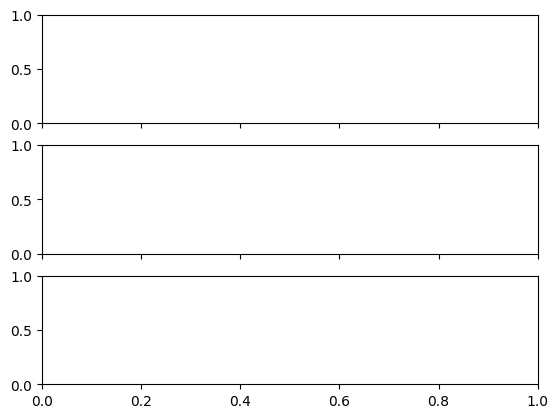

In [13]:
# Load in the .pkl files
with open('backup-backup/shap_values_gaussian.pkl', 'rb') as f:
    shap_gaussian = pickle.load(f)

with open('backup-backup/shap_values_zeroed.pkl', 'rb') as f:
    shap_zeroed = pickle.load(f)

normal = shap_gaussian[0]
normal2 = shap_zeroed[0]
gaussian_250 = shap_gaussian[1]
gaussian_500 = shap_gaussian[2]
zeroed_250 = shap_zeroed[1]
zeroed_500 = shap_zeroed[2]    

normal_z = np.asarray(normal).mean(axis=0).mean(axis=0)[0].mean(axis=0)
normal_z_2 = np.asarray(normal2).mean(axis=0).mean(axis=0)[0].mean(axis=0)
gaussian_250_z = np.asarray(gaussian_250).mean(axis=0).mean(axis=0)[0].mean(axis=0)
gaussian_500_z = np.asarray(gaussian_500).mean(axis=0).mean(axis=0)[0].mean(axis=0)
zeroed_250_z = np.asarray(zeroed_250).mean(axis=0).mean(axis=0)[0].mean(axis=0)
zeroed_500_z = np.asarray(zeroed_500).mean(axis=0).mean(axis=0)[0].mean(axis=0)

x = np.linspace(0, 308 / 512 * 1000, 308)
y = np.zeros(308)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]

fig, (ax1 ,ax2, ax3) = plt.subplots(nrows=3, sharex=True)

combined = np.asarray([normal_z_2, zeroed_250_z, zeroed_500_z])




In [4]:
def normalize(a):
    return 2.*(a - np.min(a))/np.ptp(a)-1

In [5]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

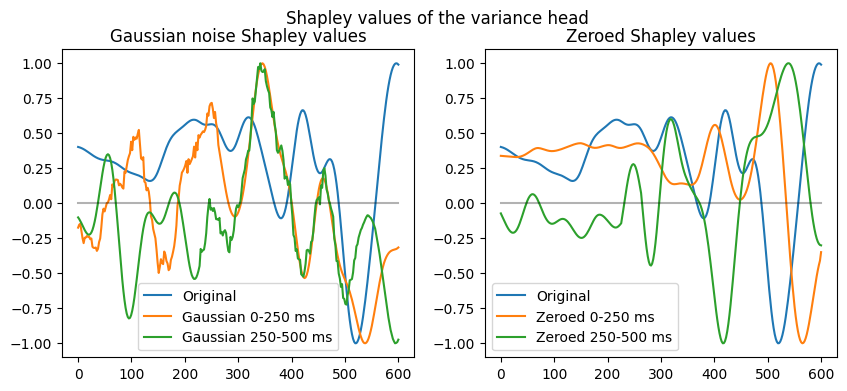

In [15]:
# Load in the .pkl files
with open('results_pickled/shap_values_gaussian.pkl', 'rb') as f:
    shap_gaussian = pickle.load(f)

with open('results_pickled/shap_values_zeroed.pkl', 'rb') as f:
    shap_zeroed = pickle.load(f)

normal = shap_gaussian[0]
normal2 = shap_zeroed[0]
gaussian_250 = shap_gaussian[1]
gaussian_500 = shap_gaussian[2]
zeroed_250 = shap_zeroed[1]
zeroed_500 = shap_zeroed[2]

normal_z = np.asarray(normal).mean(axis=0).mean(axis=0)[0].mean(axis=0)
normal_z_2 = np.asarray(normal2).mean(axis=0).mean(axis=0)[0].mean(axis=0)
gaussian_250_z = np.asarray(gaussian_250).mean(axis=0).mean(axis=0)[0].mean(axis=0)
gaussian_500_z = np.asarray(gaussian_500).mean(axis=0).mean(axis=0)[0].mean(axis=0)
zeroed_250_z = np.asarray(zeroed_250).mean(axis=0).mean(axis=0)[0].mean(axis=0)
zeroed_500_z = np.asarray(zeroed_500).mean(axis=0).mean(axis=0)[0].mean(axis=0)

normal_z = moving_average(normal_z, n=18)
normal_z_2 = moving_average(normal_z_2, n=18)
gaussian_250_z = moving_average(gaussian_250_z, n=18)
gaussian_500_z = moving_average(gaussian_500_z, n=18)
zeroed_250_z = moving_average(zeroed_250_z, n=18)
zeroed_500_z = moving_average(zeroed_500_z, n=18)


zeroes_line = np.zeros(291)

x = np.linspace(0, 600, len(normal_z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(x, normalize(normal_z), label="Original")
ax1.plot(x, normalize(gaussian_250_z), label="Gaussian 0-250 ms")
ax1.plot(x, normalize(gaussian_500_z), label="Gaussian 250-500 ms")
ax1.plot(x, zeroes_line, alpha=0.3, color="black")
ax1.legend()
ax1.set_title("Gaussian noise Shapley values")
ax2.plot(x, normalize(normal_z_2), label="Original")
ax2.plot(x, normalize(zeroed_250_z), label="Zeroed 0-250 ms")
ax2.plot(x, normalize(zeroed_500_z), label="Zeroed 250-500 ms")
ax2.plot(x, zeroes_line, alpha=0.3, color="black")
ax2.set_title("Zeroed Shapley values")
ax2.legend()
fig.suptitle("Shapley values of the variance head")
y = np.zeros(308)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2

x = np.linspace(-3,3)
y = np.cumsum(np.random.randn(50))+6

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()
extent